# Import needed modules

In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=21020f5aeede72e9a844eb18bc4cffd2a5c0578778037c1aa6e057685fb7ef4a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import wget

url = "https://storage.googleapis.com/dataset_deeplearning/CoLeaf_DATASET.zip"
file_name = "CoLeaf_DATASET.zip"

wget.download(url, file_name)

print(f"{file_name} telah berhasil diunduh.")


CoLeaf_DATASET.zip telah berhasil diunduh.


In [4]:
import zipfile

CoLeaf = zipfile.ZipFile('CoLeaf_DATASET.zip')
CoLeaf.extractall('/content')
CoLeaf.close()

In [5]:
def count_image_files(folder_path):
    def count_images(folder_name):
        folder_path_full = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_path_full):
            image_count = sum(1 for file in os.listdir(folder_path_full) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')))
            print(f"Folder '{folder_name}' contains {image_count} image files.")
            return image_count
        return 0

    folder_names = os.listdir(folder_path)
    image_counts = list(map(count_images, folder_names))
    total_image_count = sum(image_counts)

    print(f"\nTotal image files in all folders: {total_image_count}")

# Specify the path to the 'CoLeaf_DATASET' folder
dataset_folder_path = '/content/CoLeaf_DATASET'

# Call the function to count image files in each folder
count_image_files(dataset_folder_path)


Folder 'manganese-Mn' contains 83 image files.
Folder 'nitrogen-N' contains 64 image files.
Folder 'magnesium-Mg' contains 79 image files.
Folder 'potasium-K' contains 96 image files.
Folder 'iron-Fe' contains 65 image files.
Folder 'more-deficiencies' contains 104 image files.
Folder 'boron-B' contains 101 image files.
Folder 'calcium-Ca' contains 162 image files.
Folder 'healthy' contains 6 image files.
Folder 'phosphorus-P' contains 246 image files.

Total image files in all folders: 1006


In [6]:
# Path ke folder CoLeaf_DATASET
dataset_folder = '/content/CoLeaf_DATASET'

# Fungsi untuk menghitung jumlah file dalam setiap folder
def count_files_in_folder(folder):
    folder_path = os.path.join(dataset_folder, folder)
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Fungsi untuk menghitung rata-rata jumlah file dalam folder
def calculate_average_file_count(folder_counts):
    total_files = sum(folder_counts)
    num_folders = len(folder_counts)
    return total_files / num_folders if num_folders > 0 else 0

# Fungsi untuk menghapus folder berdasarkan kriteria
def delete_folders(folder_info):
    folder, count = folder_info
    folder_path = os.path.join(dataset_folder, folder)
    deleted_file_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
            deleted_file_count += 1

    os.rmdir(folder_path)
    return folder, deleted_file_count

# Menghitung jumlah file dalam setiap folder
folders = os.listdir(dataset_folder)
folder_counts = list(map(count_files_in_folder, folders))

# Menghitung rata-rata jumlah file
average_file_count = calculate_average_file_count(folder_counts)

# Menyaring folder yang ingin dihapus berdasarkan kriteria
deleted_folders = list(filter(lambda folder_count: folder_count[1] < average_file_count, zip(folders, folder_counts)))

# Menghapus folder yang sesuai dengan kriteria dan mencatat jumlah file yang dihapus
deleted_folder_info = list(map(delete_folders, deleted_folders))

# Menghitung total file yang dihapus
total_deleted_files = sum(deleted_count for _, deleted_count in deleted_folder_info)

print(f"Rata-rata jumlah file: {average_file_count}")
print(f"Total file yang dihapus: {total_deleted_files}")
if deleted_folder_info:
    print("Folder dengan jumlah file di bawah rata-rata telah dihapus:")
    for folder, deleted_count in deleted_folder_info:
        print(f"- {folder}: {deleted_count} file dihapus")
else:
    print("Tidak ada folder yang dihapus.")


Rata-rata jumlah file: 100.6
Total file yang dihapus: 393
Folder dengan jumlah file di bawah rata-rata telah dihapus:
- manganese-Mn: 83 file dihapus
- nitrogen-N: 64 file dihapus
- magnesium-Mg: 79 file dihapus
- potasium-K: 96 file dihapus
- iron-Fe: 65 file dihapus
- healthy: 6 file dihapus


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [7]:
# Generate data paths with labels
data_dir = 'CoLeaf_DATASET'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
df

,filepaths,labels
0,CoLeaf_DATASET/more-deficiencies/K_P (9).JPG,more-deficiencies
1,CoLeaf_DATASET/more-deficiencies/N_P (10).jpg,more-deficiencies
2,CoLeaf_DATASET/more-deficiencies/N_P (15).jpg,more-deficiencies
3,CoLeaf_DATASET/more-deficiencies/K_P (14).jpg,more-deficiencies
4,CoLeaf_DATASET/more-deficiencies/N_P (1).jpg,more-deficiencies
...,...,...
608,CoLeaf_DATASET/phosphorus-P/P (39).jpg,phosphorus-P
609,CoLeaf_DATASET/phosphorus-P/P (131).jpg,phosphorus-P
610,CoLeaf_DATASET/phosphorus-P/P (79).jpg,phosphorus-P
611,CoLeaf_DATASET/phosphorus-P/P (16).jpg,phosphorus-P


### **Split dataframe into train, valid, and test**

In [9]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [10]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 490 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 50 validated image filenames belonging to 4 classes.


In [11]:
# # Create ImageDataGenerator with augmentation
# tr_gen = ImageDataGenerator(
#     preprocessing_function=scalar,
#     rotation_range=20,  # Rotasi gambar
#     width_shift_range=0.2,  # Geser gambar secara horizontal
#     height_shift_range=0.2,  # Geser gambar secara vertikal
#     shear_range=0.2,  # Shearing transformation
#     zoom_range=0.2,  # Zoom gambar
#     horizontal_flip=True,  # Flip gambar secara horizontal
#     vertical_flip=True,  # Flip gambar secara vertikal
#     fill_mode='nearest'  # Cara mengisi pixel yang kosong setelah transformasi
# )

# # Buat generator untuk data train dengan augmentasi
# train_gen = tr_gen.flow_from_dataframe(
#     train_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=True,
#     batch_size=batch_size
# )

# # Validasi dan test generator tetap menggunakan pengaturan sebelumnya tanpa augmentasi
# valid_gen = ts_gen.flow_from_dataframe(
#     valid_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=True,
#     batch_size=batch_size
# )

# test_gen = ts_gen.flow_from_dataframe(
#     test_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=False,
#     batch_size=test_batch_size
# )


In [11]:
# Create ImageDataGenerator with augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Flip gambar secara horizontal
    vertical_flip=True,  # Flip gambar secara vertikal
    fill_mode='nearest'  # Cara mengisi pixel yang kosong setelah transformasi
)

# Buat generator untuk data train dengan augmentasi
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validasi dan test generator tetap menggunakan pengaturan sebelumnya tanpa augmentasi
ts_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Flip gambar secara horizontal
    vertical_flip=True,  # Flip gambar secara vertikal
    fill_mode='nearest'  # Cara mengisi pixel yang kosong setelah transformasi
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 490 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 50 validated image filenames belonging to 4 classes.


### **Show sample from train data**

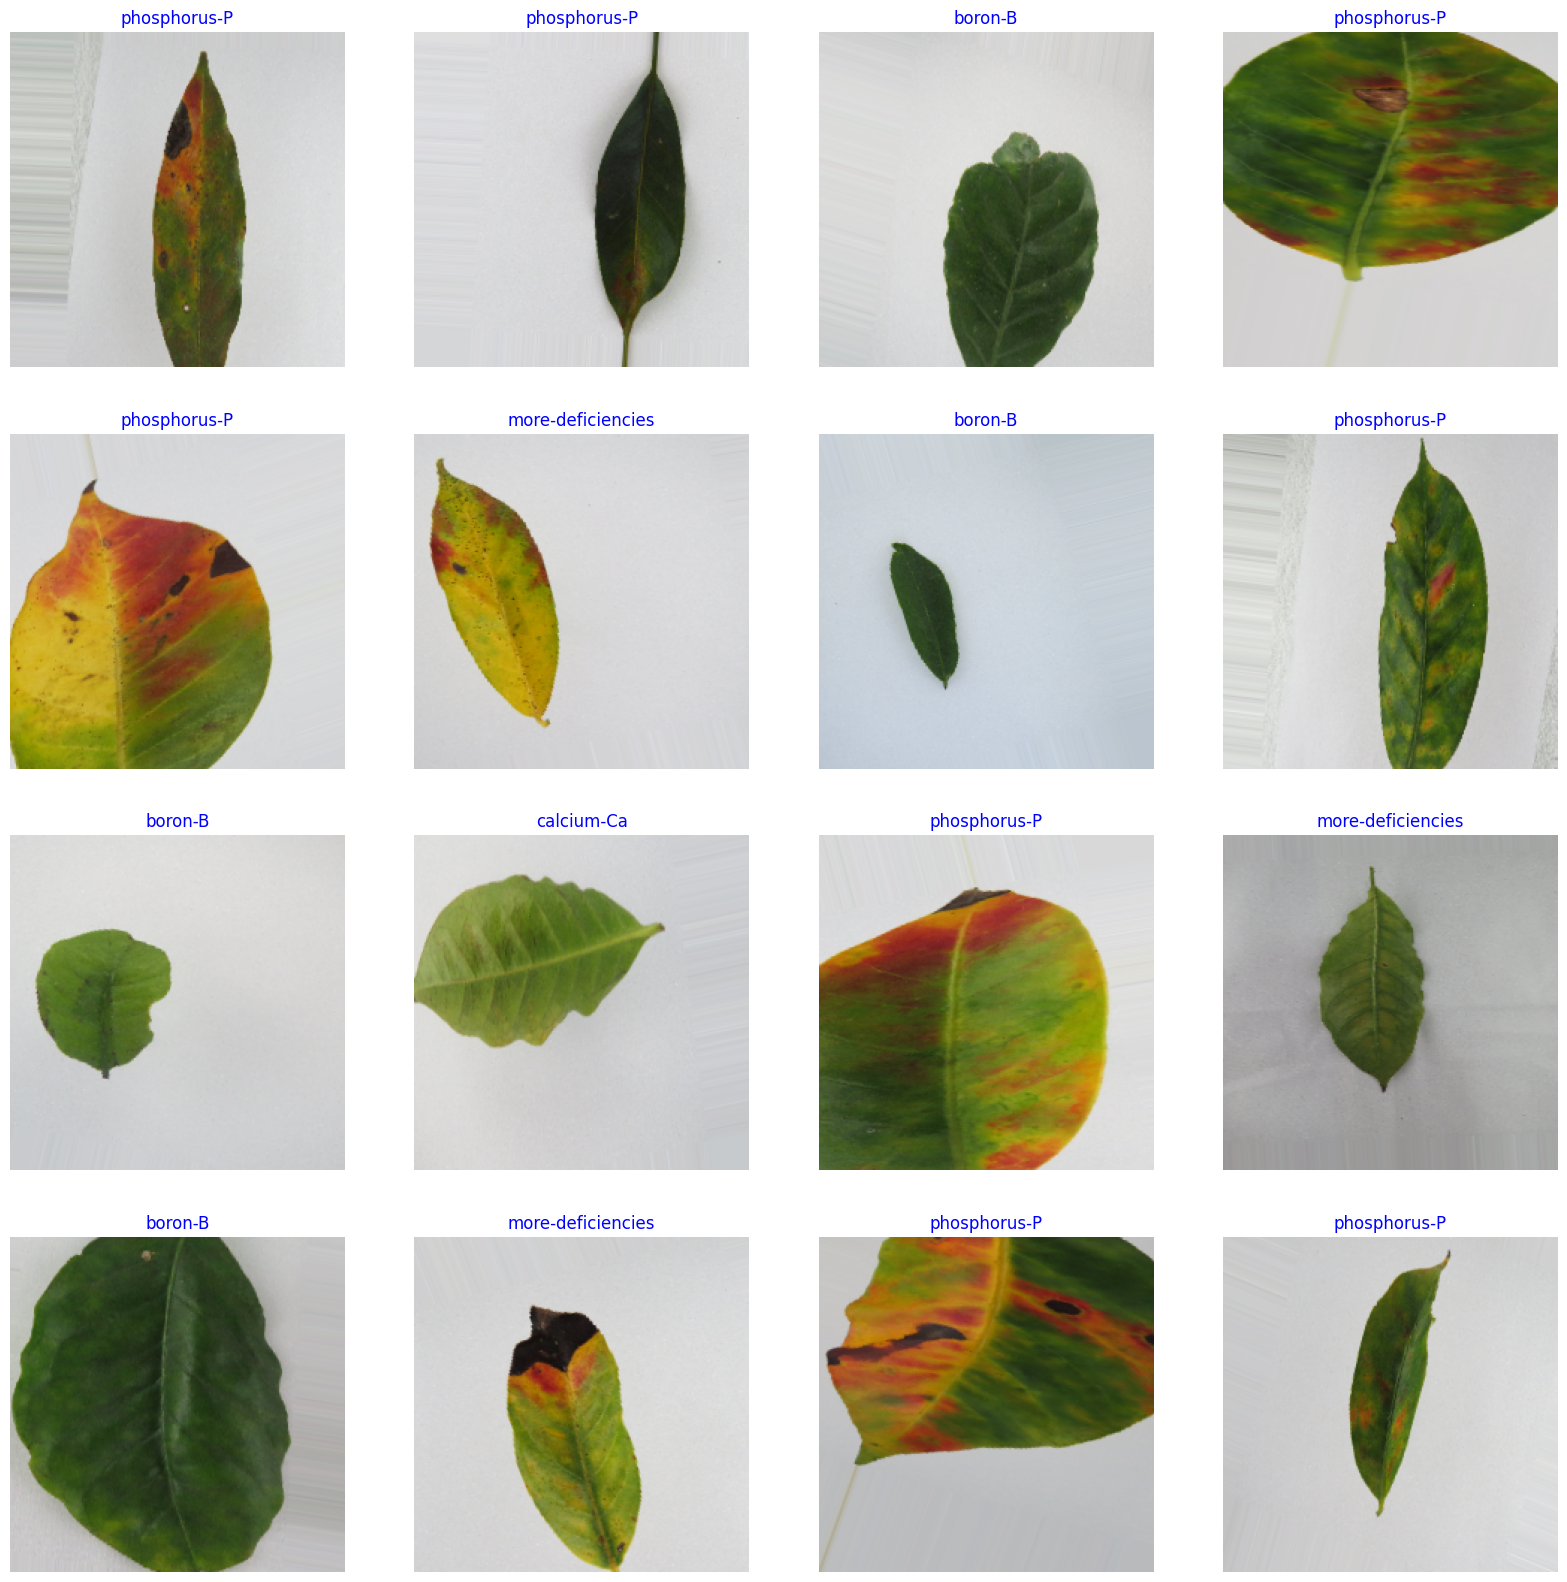

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [13]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.5, seed= 123),
    Dense(class_count, activation= 'softmax')
])

# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4383655 (16.72 MB)
Trainable params: 43390

#### **Train model**

In [14]:
# Jumlah epoch dan batch size
epochs = 50
batch_size = 16

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    steps_per_epoch=len(train_gen),  # Jumlah langkah per epoch diatur ke panjang generator train
    validation_steps=len(valid_gen),  # Langkah validasi set ke panjang generator validasi
    shuffle=False  # Shuffling sudah dilakukan di dalam generator
)


Epoch 1/50
31/31 [==============================] - 82s 2s/step - loss: 8.6021 - accuracy: 0.6122 - val_loss: 10.3989 - val_accuracy: 0.4932
Epoch 2/50
31/31 [==============================] - 44s 1s/step - loss: 7.7673 - accuracy: 0.7347 - val_loss: 9.3201 - val_accuracy: 0.5342
Epoch 3/50
31/31 [==============================] - 47s 2s/step - loss: 7.2932 - accuracy: 0.7531 - val_loss: 7.6927 - val_accuracy: 0.7671
Epoch 4/50
31/31 [==============================] - 45s 1s/step - loss: 6.8442 - accuracy: 0.7939 - val_loss: 7.1416 - val_accuracy: 0.7123
Epoch 5/50
31/31 [==============================] - 47s 2s/step - loss: 6.4974 - accuracy: 0.7837 - val_loss: 6.2662 - val_accuracy: 0.8904
Epoch 6/50
31/31 [==============================] - 48s 2s/step - loss: 6.1040 - accuracy: 0.8000 - val_loss: 6.0344 - val_accuracy: 0.7808
Epoch 7/50
31/31 [==============================] - 46s 1s/step - loss: 5.7961 - accuracy: 0.8020 - val_loss: 5.6930 - val_accuracy: 0.8082
Epoch 8/50
31/31 [=

In [ ]:
# batch_size = 16   # set batch size for training
# epochs = 10   # number of all epochs in training

# history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
#                     validation_steps= None, shuffle= False)

#### **Display model performance**

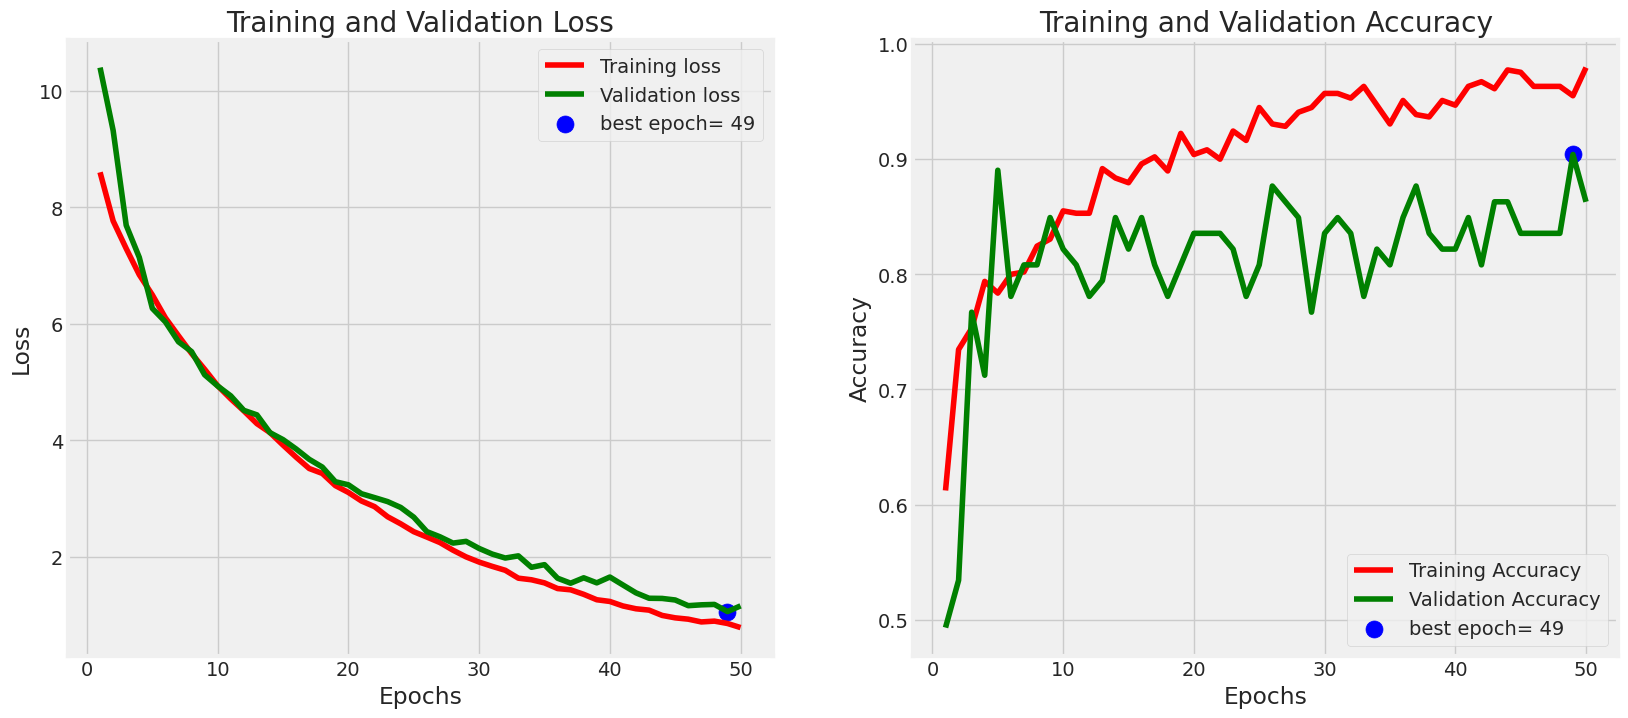

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 5s 5s/step - loss: 1.2261 - accuracy: 0.8400
Train Loss:  0.6708781123161316
Train Accuracy:  1.0
--------------------
Validation Loss:  1.8483929634094238
Validation Accuracy:  0.625
--------------------
Test Loss:  1.2261484861373901
Test Accuracy:  0.8399999737739563


# **Get Predictions**

In [17]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

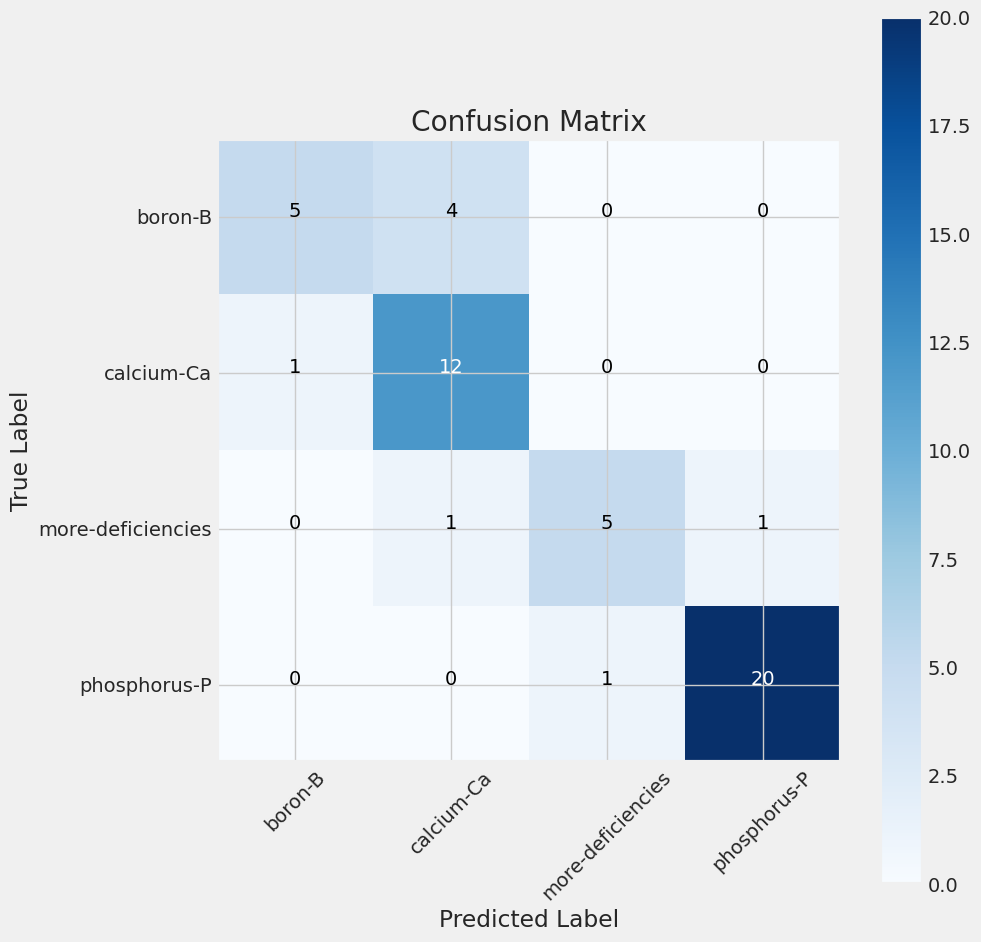

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

          boron-B       0.83      0.56      0.67         9
       calcium-Ca       0.71      0.92      0.80        13
more-deficiencies       0.83      0.71      0.77         7
     phosphorus-P       0.95      0.95      0.95        21

         accuracy                           0.84        50
        macro avg       0.83      0.79      0.80        50
     weighted avg       0.85      0.84      0.84        50



#### **Save model**

In [20]:
model_name = model.input_names[0][:-6]
subject = 'Coffee Leaf Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Coffee Leaf Diseases-84.00.h5
weights were saved as efficientnetb0-Coffee Leaf Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
# class_dict = train_gen.class_indices
# img_size = train_gen.image_shape
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join(save_path, csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [21]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [22]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
#from tensorflow import keras
import random
from PIL import Image, ImageOps
import numpy as np

import warnings
warnings.filterwarnings("ignore")


st.set_page_config(
    page_title="Coffe Leaf Disease Detection",
    page_icon = ":coffee:",
    initial_sidebar_state = 'auto'
)
hide_streamlit_style = """
            <style>
            #MainMenu {visibility: hidden;}
            footer {visibility: hidden;}
            </style>
            """
st.markdown(hide_streamlit_style, unsafe_allow_html=True)

def prediction_cls(prediction):
    for key, clss in class_names.items():
        if np.argmax(prediction)==clss:

            return key


with st.sidebar:
        st.image('coleaf.jpg')
        st.title("Kelompok 7 - Sains Data ITERA")
        st.subheader("Accurate detection of diseases present in the Coffee leaves. This helps an user to easily detect the disease and identify it's cause.")


@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('CoLeaf.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()
    #model = keras.Sequential()
    #model.add(keras.layers.Input(shape=(224, 224, 4)))


st.write("""
         # Coffee Leaf Disease Detection with Remedy Suggestion
         """
         )

file = st.file_uploader("", type=["jpg", "png"])
def import_and_predict(image_data, model):
        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.Resampling.LANCZOS)
        img = np.asarray(image)
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    x = random.randint(98,99)+ random.randint(0,99)*0.01
    st.sidebar.error("Accuracy : " + str(x) + " %")

    class_names = ['boron-B', 'calcium-Ca', 'more-deficiencies', 'phosphorus-P']

    string = "Detected Disease : " + class_names[np.argmax(predictions)]
    if class_names[np.argmax(predictions)] == 'boron-B':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Pastikan tanaman kopi mendapat pupuk boron sesuai petunjuk. Siram tanaman dengan benar, hindari genangan air. Lakukan analisis tanah untuk pemahaman yang lebih baik. Pantau tanaman dan daun untuk deteksi dini gejala kekurangan boron.")


    elif class_names[np.argmax(predictions)] == 'calcium-Ca':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan kalsium pada tanaman kopi, perlu dilakukan pemupukan dengan pupuk kalsium sesuai petunjuk penggunaannya. Pastikan pH tanah berada dalam kisaran optimal agar kalsium dapat diserap dengan baik. Melakukan analisis tanah sangat penting untuk mengetahui tingkat kekurangan kalsium secara spesifik guna perencanaan pemupukan yang tepat. Selain itu, pantau secara rutin tanaman untuk mengidentifikasi tanda-tanda kekurangan kalsium dan lakukan perawatan yang diperlukan. Menggunakan bahan organik seperti kompos juga bisa membantu meningkatkan ketersediaan kalsium dalam tanah.")

    elif class_names[np.argmax(predictions)] == 'more-deficiencies':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan nutrisi pada tanaman kopi secara umum, lakukan analisis tanah secara rutin untuk memahami kebutuhan nutrisi tanaman. Berdasarkan hasil analisis, lakukan pemupukan yang tepat dengan pupuk yang sesuai dosis dan jenisnya. Pantau tanaman secara teratur untuk mengidentifikasi gejala kekurangan nutrisi dan tanggap dengan perawatan yang sesuai seperti pemupukan tambahan jika dibutuhkan. Pastikan pH tanah berada dalam kisaran optimal dan dapatkan saran langsung dari ahli pertanian untuk rekomendasi yang lebih spesifik. Dengan pendekatan ini, Anda dapat memastikan tanaman kopi mendapatkan nutrisi yang dibutuhkan untuk pertumbuhan dan produktivitas yang maksimal.")

    elif class_names[np.argmax(predictions)] == 'phosphorus-P':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan fosfor pada tanaman kopi, tambahkan pupuk fosfor ke tanah sesuai petunjuk penggunaannya. Pastikan pH tanah optimal agar tanaman dapat menyerap fosfor dengan baik. Lakukan analisis tanah secara teratur untuk memantau dan menyesuaikan pemupukan sesuai kebutuhan tanaman. Pemupukan fosfor yang tepat penting untuk pertumbuhan akar, pembungaan, dan kualitas hasil panen kopi.")


Writing app.py


In [23]:
!pip install pyngrok

In [24]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-12-20 07:59:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  14.0MB/s    in 0.9s    

2023-12-20 07:59:02 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [25]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [26]:
get_ipython().system_raw('./ngrok http 8501 &')

In [27]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
!streamlit run /content/drive/MyDrive/MLDP/app.py